In [1]:
''' Code from Haodong Qin
edited by Iulia Rusu 
'''

import sys, os #, re, glob, socket, glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns





In [2]:
#import sci-kit learn for logistic regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

### 1: Functions needed for geodesic projection

In [3]:
def Mobius_addition(x,y,c):

    # x,y are N-dim vectors, c is the curvature of the hyperbolic space
    # vector addition in hyperbolic space

    top = (1 + 2*c* np.dot(x,y) + c* np.dot(y,y))*x + (1-c*np.dot(x,x))*y
    bottom = 1 + 2*c* np.dot(x,y) + c**2*np.dot(x,x)*np.dot(y,y)
    return top/bottom


def Mobius_scalarMulti(x,r,c):

    # scalar vector multiplication
    # x is a N-dim vector, c is the curvature of the hyperbolic space

    result = 1/np.sqrt(c)*np.tanh(r*np.arctanh(np.sqrt( c*np.dot(x,x) ))) * x/np.sqrt(np.dot(x,x))
    return result 


def Geodesic_distance(x,y,c):
    
    # x,y are N-dim vectors, c is the curvature of the hyperbolic space
    # vector addition in hyperbolic space
    direc_vector = Mobius_addition(-x,y,c)
    dist = 2/np.sqrt(c)*np.arctanh(np.sqrt(c * np.dot(direc_vector,direc_vector) ))

    return dist

def Geodesic_r(t,x,y,c):

    # find the position vector on the geodesic connecting two vectors x and y 
    # when t = 0, final_position = x
    # when t = 1, final_position = y
    direc_vector = Mobius_addition(-x,y,c)

    displace_vector = Mobius_scalarMulti(direc_vector,t,c)

    final_position = Mobius_addition(x,displace_vector,c)

    return final_position

def Geodesic_projection_OptFun(t,x,y,c,p):
    # Function that is needed to optimized to find the geometric projection t
    # x,y are N-dim vectors, c is the curvature of the hyperbolic space
    # geodesic is connecting x and y
    # p is some vector 

    r_geodesic = Geodesic_r(t,x,y,c)

    dist = Geodesic_distance(p,r_geodesic,c)

    return dist


def conformal_factor(x,c):
    # deformation of the mapping from linear to hyperbolic space at position x

    lambda_c_x = 2/(1-c*np.dot(x,x))
    return lambda_c_x

def logarithmic_map(x,y,c):

    # the logarithmic_map will map a position vector y onto the tangent space at x in a hyperbolic space with curvature c
    # logarithmic_map: position in hyperbolic space -> tangent vector in tangent space
    
    minus_x_plus_y = Mobius_addition(-x,y,c)

    length_minus_x_plus_y = np.sqrt(np.dot(minus_x_plus_y,minus_x_plus_y))

    prefactor = 2/np.sqrt(c)/conformal_factor(x,c)*np.arctanh(np.sqrt(c)*length_minus_x_plus_y) 

    tangent_vector = prefactor*minus_x_plus_y/length_minus_x_plus_y

    return tangent_vector

def exponential_map(x,v,c):

    # the exponential_map will map a tangent vector v in the tangent space at x to a position vector in hyperbolic space with curvature c
    # exponential_map: tangent vector in tangent space -> position in hyperbolic space

    # first mapping the tangent vector v in linear space to vector in hyperbolic space
    length_v = np.sqrt(np.dot(v,v))
    constant_1 = np.sqrt(c)*conformal_factor(x,c)*length_v/2
    v_hyp = np.tanh(constant_1)*v/length_v/np.sqrt(c)

    # position vector in hyperbolic space:
    position_vector = Mobius_addition(x,v_hyp,c)

    return position_vector


    

### 3: doing the geometric projection

In [4]:
def hyp_to_hyp_poincare(hyp):

    t = 1
    for coord_idx in hyp.columns:

        t = t + hyp[coord_idx]**2

    t = np.sqrt(t)

    hyp_geo = hyp.copy()

    for coord_idx in hyp_geo.columns:

        hyp_geo[coord_idx] =  hyp_geo[coord_idx]/(1+t)

    return hyp_geo


In [5]:
#access hyp_emb from different notebook
%store -r SMDD_SMDV_pcoords 

In [38]:
%store -r SMDD_SMDV_pcoords_15

In [6]:
SMDD_SMDV_pcoords.shape

(26, 4)

In [39]:
#  import your data as dataframe, make sure the columns only include coordinates in the hyperbolic space
df_data = pd.DataFrame(SMDD_SMDV_pcoords_15) 

# select the point where the tangent space is located, usually at the origin
reference_point_tangent_space =  np.zeros(df_data.shape[1])

In [40]:
# transform the coordinates from native to Poincare ball
hyp_poincare = hyp_to_hyp_poincare(df_data)

# constant, this is fixed, no change
c_hyperbolicSpace = 1

# calculate the tangent vector using logrithmic map
hyp_tangent = hyp_poincare.copy()

for i in range(hyp_poincare.shape[0]):
    current_position_hyp = np.squeeze(hyp_tangent.values[i])
    hyp_tangent.iloc[i] = logarithmic_map(reference_point_tangent_space,current_position_hyp,c_hyperbolicSpace)


In [41]:
hyp_tangent


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.132885,-0.037832,-0.081913,0.033765,0.089552,0.111860,0.021530,0.159603,0.016068,0.058306,-0.033831,-0.096202,-0.013109,0.137326,0.137473
1,0.053425,-0.006180,0.114076,-0.152182,0.003348,0.085459,0.142228,-0.011387,-0.074627,0.121488,0.026354,-0.130035,0.055632,-0.087924,-0.026762
2,0.030656,0.007337,0.088636,-0.120987,0.056235,0.092507,0.133941,0.001040,-0.124110,0.112553,0.071557,-0.072779,0.026316,-0.153203,0.008548
3,-0.042085,-0.059817,-0.043399,-0.003727,0.115240,-0.014058,-0.018566,-0.144018,0.193036,0.052463,-0.030102,-0.084877,-0.157975,-0.077793,0.058582
4,-0.054009,-0.036231,-0.042281,-0.021916,0.106712,-0.024243,0.017980,-0.168388,0.195145,0.024144,-0.045452,-0.066951,-0.162310,-0.050181,0.041197
5,0.054886,-0.038127,-0.045463,0.108980,0.085709,-0.072506,-0.031747,0.161677,0.164185,0.083081,0.025538,-0.002095,0.017866,-0.086369,-0.143531
6,0.051990,-0.038512,-0.030912,0.094843,0.074390,-0.068682,-0.020075,0.169097,0.170351,0.069689,0.011804,0.004160,0.017909,-0.058445,-0.170781
7,0.133944,-0.009682,-0.077965,-0.090014,-0.112352,0.000466,-0.104523,0.057193,-0.020674,-0.014027,0.054709,0.134760,-0.134840,0.053003,0.112450
8,0.013801,-0.017755,0.113153,0.090421,0.092637,-0.036081,-0.022433,-0.025069,0.010440,-0.038687,-0.196256,0.109400,0.139200,-0.037652,0.112327
9,0.028992,-0.024847,0.100236,0.113604,0.061558,-0.039049,-0.056442,-0.032264,0.015616,0.007039,-0.180194,0.070313,0.168006,-0.041068,0.131129


In [11]:
%store -r SMDD_SMDV_labels 

In [42]:
hyp_tangent['identity'] = SMDD_SMDV_labels 

In [43]:
hyp_tangent

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,identity
0,-0.132885,-0.037832,-0.081913,0.033765,0.089552,0.111860,0.021530,0.159603,0.016068,0.058306,-0.033831,-0.096202,-0.013109,0.137326,0.137473,SMDD
1,0.053425,-0.006180,0.114076,-0.152182,0.003348,0.085459,0.142228,-0.011387,-0.074627,0.121488,0.026354,-0.130035,0.055632,-0.087924,-0.026762,SMDD
2,0.030656,0.007337,0.088636,-0.120987,0.056235,0.092507,0.133941,0.001040,-0.124110,0.112553,0.071557,-0.072779,0.026316,-0.153203,0.008548,SMDD
3,-0.042085,-0.059817,-0.043399,-0.003727,0.115240,-0.014058,-0.018566,-0.144018,0.193036,0.052463,-0.030102,-0.084877,-0.157975,-0.077793,0.058582,SMDD
4,-0.054009,-0.036231,-0.042281,-0.021916,0.106712,-0.024243,0.017980,-0.168388,0.195145,0.024144,-0.045452,-0.066951,-0.162310,-0.050181,0.041197,SMDD
5,0.054886,-0.038127,-0.045463,0.108980,0.085709,-0.072506,-0.031747,0.161677,0.164185,0.083081,0.025538,-0.002095,0.017866,-0.086369,-0.143531,SMDD
6,0.051990,-0.038512,-0.030912,0.094843,0.074390,-0.068682,-0.020075,0.169097,0.170351,0.069689,0.011804,0.004160,0.017909,-0.058445,-0.170781,SMDD
7,0.133944,-0.009682,-0.077965,-0.090014,-0.112352,0.000466,-0.104523,0.057193,-0.020674,-0.014027,0.054709,0.134760,-0.134840,0.053003,0.112450,SMDD
8,0.013801,-0.017755,0.113153,0.090421,0.092637,-0.036081,-0.022433,-0.025069,0.010440,-0.038687,-0.196256,0.109400,0.139200,-0.037652,0.112327,SMDD
9,0.028992,-0.024847,0.100236,0.113604,0.061558,-0.039049,-0.056442,-0.032264,0.015616,0.007039,-0.180194,0.070313,0.168006,-0.041068,0.131129,SMDD


In [44]:
data = hyp_tangent

In [45]:
# ON_means= np.mean(data.values[0:29, :], axis = 0)
#caluclate means across the column


SMDD_means = data[data['identity'] == 'SMDD'].iloc[:, 0:15].mean(axis=0)

In [46]:
test = data[data['identity'] == 'SMDD'].iloc[:, 0:15]

In [47]:
SMDD_means = np.array(SMDD_means)

In [48]:
SMDV_means = data[data['identity'] == 'SMDV'].iloc[:, 0:15].mean(axis=0)

In [49]:
SMDV_means = np.array(SMDV_means)

In [50]:
#subtract ON from OFF
diff_means = SMDD_means - SMDV_means

In [51]:
#normalize the difference
normalized = diff_means/np.linalg.norm(diff_means)

In [52]:
normalized

array([-0.10968728, -0.41331592,  0.2822958 , -0.33865013,  0.43243033,
       -0.00794754, -0.32869061,  0.07380555,  0.18182468,  0.378864  ,
       -0.10646914,  0.27433152,  0.07221342, -0.20386103,  0.11069862])

In [53]:
axis_trans = np.dot(data.values[:, 0:15], normalized)

In [54]:
axis_trans.shape

(26,)

In [55]:
clust_labs_reshaped = SMDD_SMDV_labels[:, np.newaxis]
clust_labs_reshaped.shape

(26, 1)

In [56]:
axis_trans_reshaped = axis_trans[:, np.newaxis]

In [57]:
combined_array = np.concatenate((axis_trans_reshaped, clust_labs_reshaped), axis=1)

In [58]:
axis_trans_df = pd.DataFrame(combined_array)

In [59]:
axis_trans_df

,0,1
0,0.026691,SMDD
1,0.046572,SMDD
2,0.065803,SMDD
3,0.1096,SMDD
4,0.078557,SMDD
5,0.081049,SMDD
6,0.072727,SMDD
7,0.001749,SMDD
8,0.121326,SMDD
9,0.119015,SMDD


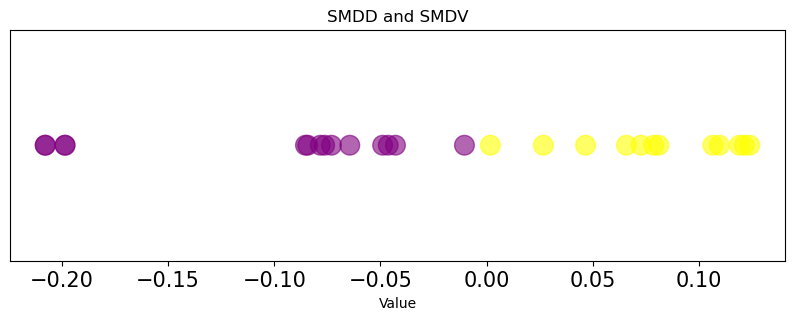

In [63]:
axis_trans_df.columns = ['Value', 'Category']

# Create a color map manually
color_map = {
    'SMDD': 'yellow',  
    'SMDV': 'purple'  
}

# Map labels to colors using the color map
label_colors = axis_trans_df['Category'].map(color_map)

# Create scatter plot with specified figure size
fig, ax = plt.subplots(figsize=(10, 3))
ax.scatter(axis_trans_df['Value'], [0] * len(axis_trans_df), c=label_colors, s=200, alpha = 0.6)
ax.set_xlabel('Value')
plt.xticks(fontsize = 15)
ax.yaxis.set_visible(False)

ax.set_title('SMDD and SMDV')

plt.show()



In [61]:
axis_trans_df

,Value,Category
0,0.026691,SMDD
1,0.046572,SMDD
2,0.065803,SMDD
3,0.1096,SMDD
4,0.078557,SMDD
5,0.081049,SMDD
6,0.072727,SMDD
7,0.001749,SMDD
8,0.121326,SMDD
9,0.119015,SMDD


In [62]:
SMDD = axis_trans_df[axis_trans_df['Category'] == 'SMDD']['Value']
SMDV = axis_trans_df[axis_trans_df['Category'] == 'SMDV']['Value']





(array([[2., 0., 4., 0., 0., 1., 2., 0., 0., 2., 0., 0., 0., 0., 0., 1.,
         0., 1., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 0., 0., 2., 0., 1.,
         0., 0., 0., 2.]]),
 array([-0.32840448, -0.29320508, -0.25800568, -0.22280628, -0.18760689,
        -0.15240749, -0.11720809, -0.08200869, -0.04680929, -0.01160989,
         0.02358951,  0.05878891,  0.09398831,  0.12918771,  0.16438711,
         0.19958651,  0.23478591,  0.26998531,  0.30518471,  0.34038411,
         0.37558351]),
 <a list of 2 list[Polygon] objects>)

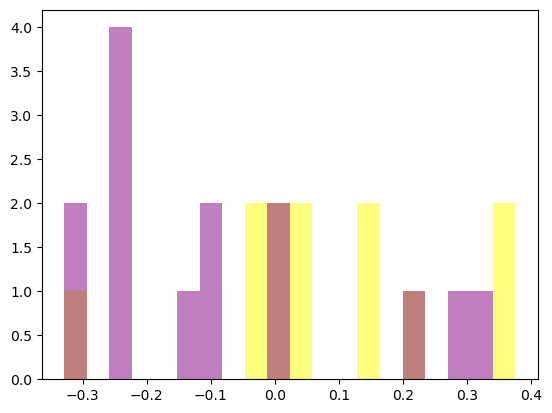

In [34]:
plt.hist([SMDV, SMDD], bins = 20, alpha=0.5, label=['SMDV', 'SMDD'], color = [ 'purple','yellow'], histtype='stepfilled')


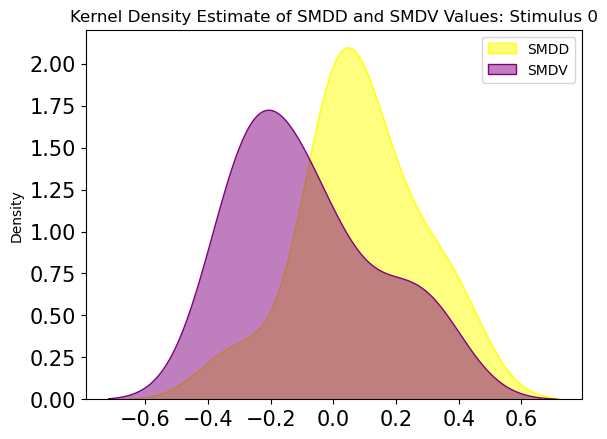

In [36]:
# Plotting KDE for each category
sns.kdeplot(SMDD, color='yellow', fill=True, alpha=0.5, label='SMDD')
sns.kdeplot(SMDV, color='purple', fill=True, alpha=0.5, label='SMDV')

# Adding labels and title
plt.xlabel('')
plt.ylabel('Density')
plt.xticks(fontsize=15 )
plt.yticks(fontsize=15 )
plt.title('Kernel Density Estimate of SMDD and SMDV Values: Stimulus 0')
plt.legend()

# Show the plot
plt.show()

#what should the x-axis be?

In [ ]:
#look at distance between distributions, KS distance 

In [136]:
#use svm in 8 dim space 
#also try a logistic regression, using 8 dim tangent space data and correspoding labels
#try MNE on tangent space coords
y = data.iloc[:, -1]
X = data.iloc[:, 0:5]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [138]:
logreg = LogisticRegression(random_state=16)

# Train the model
logreg.fit(X_train, y_train)

LogisticRegression(random_state=16)

In [139]:
logreg.fit(X_train, y_train)

LogisticRegression(random_state=16)

In [140]:
y_pred = logreg.predict(X_test)

In [141]:
y_pred

array(['RME', 'RME', 'AVA', 'RME', 'AVA', 'AVA', 'AVA', 'AVA', 'AVA',
       'AVA', 'AVA', 'AVA', 'RME', 'AVA', 'RME'], dtype=object)

In [143]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[4, 1],
       [6, 4]])

NameError: name 'Text' is not defined

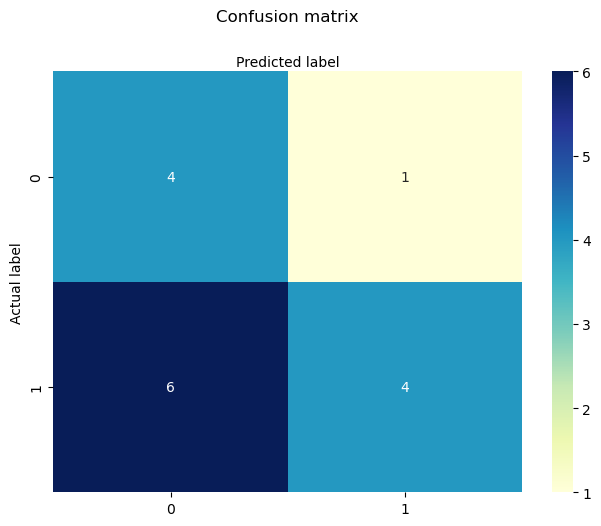

In [144]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5,257.44,'Predicted label');

In [149]:
target_names = ['AVA', 'RME']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         AVA       0.40      0.80      0.53         5
         RME       0.80      0.40      0.53        10

    accuracy                           0.53        15
   macro avg       0.60      0.60      0.53        15
weighted avg       0.67      0.53      0.53        15

